**Import Python Packages**

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

## Demographic Data Processing

The functions below retrieve block level data for a state using the state fips code from census API, then retrieves data from appropriate
columns in GEOID, convert to .csv to easily manipulate individual state data

In [2]:
#code chunk by Melisande Teng 

variables = [
    # pop
    "P001001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]


def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [3]:
#Specify MI code to pull demographic data at block level
demographic_block_data = block_data_for_state('26')
#Now we have the block data by county 

**Read in shapefile**

In [4]:
#Read Census block shapefiles
#Source: (https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Blocks)
#^This links to page that has the 2010_tabblock10... I do not know where 
#the 2017 came from - I think I downloaded from our AWS? CG used tl_2017... I don't know why...
blocks_2010_shp = gpd.read_file("tl_2010_26_tabblock10/tl_2010_26_tabblock10.shp")

In [5]:
blocks_2010_shp.head(1)


,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,26,001,000100,1031,260010001001031,Block 1031,G5040,R,None,None,S,27605,0,+44.7758368,-083.4159109,"POLYGON ((-83.41658 44.77727, -83.41636 44.777..."


In [6]:
demographic_block_data.head(1)

,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,geoid
0,22,22,0,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1045, Block Group 1, Census Tract 9601, ...",26,009,960100,1045,260099601001045


In [7]:
#Given that the df and gdf have the same number of rows, want 
#to check to see if geoids overlap
d_df = demographic_block_data
d_gdf = blocks_2010_shp
gdf_set = set(d_gdf.GEOID10.str.lower().unique())
df_set = set(d_df.geoid.str.lower().unique())
difference = df_set.symmetric_difference(gdf_set)
intersection = gdf_set.intersection(df_set)

In [8]:
intersect = df_set.intersection(gdf_set)

In [9]:
len(intersect)
#So, the length of the set is the same as the number of geoids
#indicates they all match, so should be good to join!

329885

In [ ]:
#Set/confirm shapefile projections by comparing precinct shapefile and block level shapefile, 
#converting them to match
#^don't know about this...

**Join data with shape (block level demographic data with block level shapefile)**

In [19]:
demographic_block = d_gdf.merge(d_df, how = 'inner', left_on = 'GEOID10', right_on = 'geoid', indicator = True)

In [21]:
print(len(demographic_block.GEOID10))
print(len(d_gdf.GEOID10))
print(demographic_block.TOTPOP.sum())
print(d_df.TOTPOP.sum())

329885
329885
9883640
9883640


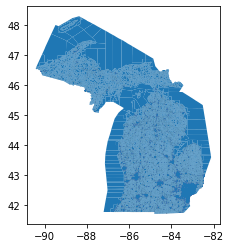

In [20]:
demographic_block.plot()

**Prorate demographic and Voting Population data from census block level to precinct level**
< I am not sure why I put this in before - am I supposed to do this?

In [ ]:
#Code from cg, still needs to be adapted after elections complete to make projections match
#Place this block after the Election Processing
proj =  {'init':'epsg:4326'}
block_demo.crs = proj
vtd.crs = proj

import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
pieces = maup.assign(block_demo, vtd)

vtd[keys] = block_demo[keys].astype(int).groupby(pieces).sum()

vtd.head()

print(vtd.TOTPOP.sum())
print(block_demo.TOTPOP.sum())

## Presidential ELECTION PROCESSING

**Import 2016 Election Data: Shape Files (gdf)**

In [27]:
#Precinct and congressional district shapefiles from State of MI GIS portal
#Source: State of Michigan GIS Open Data Portal(http://gis-michigan.opendata.arcgis.com/datasets/2016-voting-precincts?geometry=94.224%2C43.115%2C-91.752%2C84.203)
precincts_shp_2016 = gpd.read_file("2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")
#voting_precincts_shp_2016.plot()

#Why do we need anything other than 2016 voting precincts for our purposes?
#----------------------------------------------------
#Voting Tabulation District shp from Census 2010 data
vtd_2012 = gpd.read_file("tl_2012_26_vtd10/tl_2012_26_vtd10.shp")
#vtd_2012.plot()


In [29]:
#To select things for single county... Mask = series that is T or F for every index. County Fips for Alleghan County (ex. where there is a ward) = "026005"
foo = precincts_shp_2016[(precincts_shp_2016.CountyFips == "005")
                   &(precincts_shp_2016.Label.str.contains("Holland"))]
#foo = filter for City of Holland

In [30]:
#Make column for ward, precinct, Label/city
#For alleghan county ex, need to cut off 9, 11, 12, 13 - use foo to capture last 3 digits
foo.VTD2016
bar = "0053864004009"

In [34]:
def get_precinct_number(VTD2016):
    last_3 = VTD2016[-3:] 
    return last_3.lstrip("0")

In [40]:
def get_ward(VTD2016):
    ward = VTD2016[-5:-3].lstrip("0")
    return ward


In [41]:
foo.VTD2016.apply(get_ward)

86    4
87    5
88    5
89    5
Name: VTD2016, dtype: object

In [43]:
# combine to use multiple variables:
def precinct_mod(row):
    label = row['Label']
    vtd2016 = row['VTD2016']
    
    if 'City of' in label:
        replace_label = label.replace("City of", "")
        replace_label = replace_label + " City"
        
    elif 'Township' in label:
        replace_label = label
        
    ward = vtd2016[-5:-3]
    precinct_num = vtd2016[-3:].lstrip("0")
    if ward != '00':
        ward = ward.lstrip("0")
        replace_label = replace_label + "; Ward " + ward + "; Precinct " + precinct_num
    elif ward == '00':
        replace_label = replace_label + "; " + precinct_num
    return replace_label
         
        

In [44]:
precincts_shp_2016.apply(precinct_mod, axis = 1)

0         Dearborn City; 1
1         Dearborn City; 2
2         Dearborn City; 3
3         Dearborn City; 4
4         Dearborn City; 5
               ...        
4805     Genoa Township; 7
4806    Oceola Township; 5
4807    Oceola Township; 1
4808    Oceola Township; 2
4809    Oceola Township; 4
Length: 4810, dtype: object

In [45]:
gdf = precincts_shp_2016
gdf['precinct'] = gdf.apply(precinct_mod, axis = 1)
gdf.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,precinct
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",Dearborn City; 1
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",Dearborn City; 2
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",Dearborn City; 3
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20...",Dearborn City; 4
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20...",Dearborn City; 5


In [66]:
# intersect
gdf_set = set(gdf.precinct.str.lower().unique())
df_set = set(df.precinct.str.lower().unique())
difference = df_set.symmetric_difference(gdf_set)
intersection = gdf_set.intersection(df_set)

In [71]:
len(difference)

5254

In [72]:
from reference_data import geoid_to_county_name
geoid_to_county_name

{'01001': 'Autauga County',
 '01003': 'Baldwin County',
 '01005': 'Barbour County',
 '01007': 'Bibb County',
 '01009': 'Blount County',
 '01011': 'Bullock County',
 '01013': 'Butler County',
 '01015': 'Calhoun County',
 '01017': 'Chambers County',
 '01019': 'Cherokee County',
 '01021': 'Chilton County',
 '01023': 'Choctaw County',
 '01025': 'Clarke County',
 '01027': 'Clay County',
 '01029': 'Cleburne County',
 '01031': 'Coffee County',
 '01033': 'Colbert County',
 '01035': 'Conecuh County',
 '01037': 'Coosa County',
 '01039': 'Covington County',
 '01041': 'Crenshaw County',
 '01043': 'Cullman County',
 '01045': 'Dale County',
 '01047': 'Dallas County',
 '01049': 'DeKalb County',
 '01051': 'Elmore County',
 '01053': 'Escambia County',
 '01055': 'Etowah County',
 '01057': 'Fayette County',
 '01059': 'Franklin County',
 '01061': 'Geneva County',
 '01063': 'Greene County',
 '01065': 'Hale County',
 '01067': 'Henry County',
 '01069': 'Houston County',
 '01071': 'Jackson County',
 '01073': 

In [73]:
#Finding number of "Charter Township" Labels to see if this accounts for discrepency (Charter does not appear in df)
#Mask to remove "Charter" rows from dataset
remove_charter = gdf[(gdf.Label != 'Charter')]
remove_charter
#did not work to remove^

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,precinct
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",Dearborn City; 1
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",Dearborn City; 2
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",Dearborn City; 3
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20...",Dearborn City; 4
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20...",Dearborn City; 5
...,...,...,...,...,...,...,...,...,...,...,...
4805,4806,1805,0933186000007,093,31860,2016,Genoa Township,6.610719e+06,18986.630070,"POLYGON ((678019.208 220453.671, 677984.088 22...",Genoa Township; 7
4806,4807,1848,0936012000005,093,60120,2016,Oceola Township,8.526046e+06,12408.612226,"POLYGON ((674226.582 230029.619, 674205.136 23...",Oceola Township; 5
4807,4808,1848,0936012000001,093,60120,2016,Oceola Township,4.258013e+07,28101.267509,"POLYGON ((674058.491 233218.627, 673972.280 23...",Oceola Township; 1
4808,4809,1848,0936012000002,093,60120,2016,Oceola Township,7.200447e+06,13280.921753,"POLYGON ((672258.795 232398.214, 672291.130 23...",Oceola Township; 2


In [74]:
mask = gdf[gdf.CountyFips == '005']
mask
#precincts_shp_2016[(precincts_shp_2016.CountyFips == "005")

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,precinct
69,70,24,0050126000001,005,01260,2016,City of Allegan,1.520515e+07,27763.275509,"POLYGON ((513778.494 222001.410, 513410.908 22...",Allegan City; 1
70,71,25,0050126000002,005,01260,2016,City of Allegan,5.126924e+06,12777.389783,"POLYGON ((511376.262 220097.564, 511404.104 22...",Allegan City; 2
71,72,26,0050128000001,005,01280,2016,Allegan Township,8.792993e+07,55171.527066,"POLYGON ((513766.037 222228.599, 513480.905 22...",Allegan Township; 1
72,73,27,0050128000002,005,01280,2016,Allegan Township,6.431700e+07,42518.946276,"POLYGON ((518018.119 217487.315, 516998.501 21...",Allegan Township; 2
73,74,28,0051370000001,005,13700,2016,Casco Township,1.854138e+08,57308.570654,"POLYGON ((489265.070 207602.820, 489221.697 20...",Casco Township; 1
74,75,29,0051520000001,005,15200,2016,Cheshire Township,1.710239e+08,52288.791305,"POLYGON ((500011.164 217310.299, 500401.976 21...",Cheshire Township; 1
75,76,30,0051672000001,005,16720,2016,Clyde Township,1.694473e+08,56756.648215,"POLYGON ((494530.832 227057.587, 494565.707 22...",Clyde Township; 1
76,77,31,0052268000001,005,22680,2016,Dorr Township,7.795300e+07,51958.292997,"POLYGON ((521024.096 246411.890, 520975.630 24...",Dorr Township; 1
77,78,32,0052268000002,005,22680,2016,Dorr Township,5.915112e+07,36266.044779,"POLYGON ((527423.801 246417.851, 527425.297 24...",Dorr Township; 2
78,79,33,0052268000003,005,22680,2016,Dorr Township,3.659305e+07,31549.257669,"POLYGON ((522634.673 241622.366, 522735.468 24...",Dorr Township; 3


In [101]:
#lambda is anonymous fxn - can only use in the one spot. get_ward is nicer to use, but lambda can be used for qui
foo.VTD2016.apply(lambda VTD2016:VTD2016[-5:-3])

86    04
87    05
88    05
89    05
Name: VTD2016, dtype: object

In [48]:
precincts_shp_2016.Id.nunique()


4769

In [49]:
precincts_shp_2016.Label

0       City of Dearborn
1       City of Dearborn
2       City of Dearborn
3       City of Dearborn
4       City of Dearborn
              ...       
4805      Genoa Township
4806     Oceola Township
4807     Oceola Township
4808     Oceola Township
4809     Oceola Township
Name: Label, Length: 4810, dtype: object

In [50]:
precincts_shp_2016.VTD2016

0       1632100000001
1       1632100000002
2       1632100000003
3       1632100000004
4       1632100000005
            ...      
4805    0933186000007
4806    0936012000005
4807    0936012000001
4808    0936012000002
4809    0936012000004
Name: VTD2016, Length: 4810, dtype: object

In [51]:
precincts_shp_2016.CountyFips

0       163
1       163
2       163
3       163
4       163
       ... 
4805    093
4806    093
4807    093
4808    093
4809    093
Name: CountyFips, Length: 4810, dtype: object

**Reading 2016 Election Data Files/dataframe (df)**

In [52]:
#2016 precinct-level election data - all offices all states
precinct_election_data = pd.read_csv("2016-precinct-president.csv", 
                                     encoding='ISO-8859-1',
                                     dtype = {"county_name" : "str","precinct" : "str","district" : "str"},
                                    low_memory=False)
#specified datatype for specific columns due to error message

In [53]:
precinct_election_data.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#Filter to return data only for MI
mi_precinct_election = precinct_election_data[precinct_election_data.state_fips == 26]

In [55]:
#mi_precinct_election.head()

In [56]:
#mi_precinct_election.nunique()

In [57]:
#Number of unique precincts in each county 
foo = mi_precinct_election.groupby('county_name').precinct.nunique()
foo
#foo is a variable used to represent and unspecified entity

county_name
Alcona County         13
Alger County          11
Allegan County        46
Alpena County         18
Antrim County         17
                    ... 
Tuscola County        32
Van Buren County      34
Washtenaw County     142
Wayne County        1172
Wexford County        21
Name: precinct, Length: 83, dtype: int64

In [58]:
foo.sum()

5077

In [59]:
mi_precinct_election.office.unique()

array(['US President'], dtype=object)

In [60]:
#I included this because CG did before... we filter out the other 2 parties to match MGGG?
mi_party = mi_precinct_election[
    (mi_precinct_election.party == 'democratic')|
    (mi_precinct_election.party == 'republican')|
    (mi_precinct_election.party == 'libertarian')|
    (mi_precinct_election.party == 'green')]



In [61]:
df = mi_pivot = mi_party.pivot_table(index = ['county_name','precinct'],
                         columns = ['party'],
                        values = ['votes'],
                         aggfunc = 'sum').reset_index()
#"reset_index" turns assigned indices into columns so that mask can be applied


In [62]:
mask = df[df.precinct == "Statistical Adjustments"]
mask.shape

(56, 6)

In [63]:
#get rid of "statistical adjustment" rows
is_statistical_adjustment_mask = (df.precinct == "Statistical Adjustments")
#make opposite of above argument
~is_statistical_adjustment_mask 

0        True
1        True
2        True
3        True
4        True
        ...  
5072     True
5073     True
5074     True
5075    False
5076     True
Name: precinct, Length: 5077, dtype: bool

In [64]:
#mask to remove statistical adjustment - filter on false
remove_stat_adjust = df[(df.precinct != 'Statistical Adjustments')]
remove_stat_adjust

county_name                  precinct      votes                    \
party                                           democratic green libertarian   
0       Alcona County        ALCONA TOWNSHIP; 1        199     2          13   
1       Alcona County     CALEDONIA TOWNSHIP; 1        178     4          14   
2       Alcona County        CURTIS TOWNSHIP; 1        214    13           8   
3       Alcona County     GREENBUSH TOWNSHIP; 1        256     4          22   
4       Alcona County        GUSTIN TOWNSHIP; 1         80     6          16   
...               ...                       ...        ...   ...         ...   
5071   Wexford County         SELMA TOWNSHIP; 1        322    14          36   
5072   Wexford County        SLAGLE TOWNSHIP; 1         92     0          12   
5073   Wexford County  SOUTH BRANCH TOWNSHIP; 1         76     3           5   
5074   Wexford County   SPRINGVILLE TOWNSHIP; 1        176    10          28   
5076   Wexford County       WEXFORD TOWNSHIP; 1        110     7          17   

                  
party republican  
0            500  
1            441  
2            401  
3            501  
4            249  
...          ...  
5071         729  
5072         179  
5073         127  
5074         494  
5076         357  

[5021 rows x 6 columns]

In [65]:
df.head(55)

county_name                              precinct      votes        \
party                                                       democratic green   
0       Alcona County                    ALCONA TOWNSHIP; 1        199     2   
1       Alcona County                 CALEDONIA TOWNSHIP; 1        178     4   
2       Alcona County                    CURTIS TOWNSHIP; 1        214    13   
3       Alcona County                 GREENBUSH TOWNSHIP; 1        256     4   
4       Alcona County                    GUSTIN TOWNSHIP; 1         80     6   
5       Alcona County  HARRISVILLE CITY; Ward 1; Precinct 1         98     4   
6       Alcona County               HARRISVILLE TOWNSHIP; 1        216     6   
7       Alcona County                     HAWES TOWNSHIP; 1        160     4   
8       Alcona County                    HAYNES TOWNSHIP; 1        121     3   
9       Alcona County                    MIKADO TOWNSHIP; 1         96     4   
10      Alcona County                    MILLEN TOWNSHIP; 1         72     3   
11      Alcona County                  MITCHELL TOWNSHIP; 1         42     1   
12      Alcona County               Statistical Adjustments          0     0   
13       Alger County                  AU TRAIN TOWNSHIP; 1        199     6   
14       Alger County                      BURT TOWNSHIP; 1        101     6   
15       Alger County              GRAND ISLAND TOWNSHIP; 1         15     0   
16       Alger County                 LIMESTONE TOWNSHIP; 1         75     3   
17       Alger County                   MATHIAS TOWNSHIP; 1        111     3   
18       Alger County                      MUNISING CITY; 1        441    23   
19       Alger County                  MUNISING TOWNSHIP; 1        166     6   
20       Alger County                  MUNISING TOWNSHIP; 2        158     6   
21       Alger County                     ONOTA TOWNSHIP; 1        121     4   
22       Alger County                ROCK RIVER TOWNSHIP; 1        276    10   
23       Alger County               Statistical Adjustments          0     0   
24     Allegan County                       ALLEGAN CITY; 1        283    10   
25     Allegan County                       ALLEGAN CITY; 2        475    32   
26     Allegan County                   ALLEGAN TOWNSHIP; 1        554    10   
27     Allegan County                   ALLEGAN TOWNSHIP; 2        209     7   
28     Allegan County                     CASCO TOWNSHIP; 1        605     8   
29     Allegan County                  CHESHIRE TOWNSHIP; 1        290    13   
30     Allegan County                     CLYDE TOWNSHIP; 1        310     6   
31     Allegan County                      DORR TOWNSHIP; 1        261     7   
32     Allegan County                      DORR TOWNSHIP; 2        348    22   
33     Allegan County                      DORR TOWNSHIP; 3        330    14   
34     Allegan County                       DOUGLAS CITY; 1        528     6   
35     Allegan County                     FENNVILLE CITY; 1        204    10   
36     Allegan County                  FILLMORE TOWNSHIP; 1        227    10   
37     Allegan County                    GANGES TOWNSHIP; 1        602    13   
38     Allegan County                  GUNPLAIN TOWNSHIP; 1        743    25   
39     Allegan County                  GUNPLAIN TOWNSHIP; 2        445    11   
40     Allegan County                     HEATH TOWNSHIP; 1        348    17   
41     Allegan County      HOLLAND CITY; Ward 4; Precinct 9        370    18   
42     Allegan County     HOLLAND CITY; Ward 5; Precinct 11        316    12   
43     Allegan County     HOLLAND CITY; Ward 5; Precinct 12        312    10   
44     Allegan County     HOLLAND CITY; Ward 5; Precinct 13        335     4   
45     Allegan County                   HOPKINS TOWNSHIP; 1        306    17   
46     Allegan County                  LAKETOWN TOWNSHIP; 1        523     6   
47     Allegan County                  LAKETOWN TOWNSHIP; 2        459    14   
48     All

In [30]:
df.shape

(5077, 6)

In [31]:
bool_array = df.precinct.str.contains('Charter')
count = np.count_nonzero(bool_array)

print(count)

0


In [33]:
gdf

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,precinct_number,ward_number
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",1,
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",2,
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",3,
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20...",4,
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20...",5,
...,...,...,...,...,...,...,...,...,...,...,...,...
4805,4806,1805,0933186000007,093,31860,2016,Genoa Township,6.610719e+06,18986.630070,"POLYGON ((678019.208 220453.671, 677984.088 22...",7,
4806,4807,1848,0936012000005,093,60120,2016,Oceola Township,8.526046e+06,12408.612226,"POLYGON ((674226.582 230029.619, 674205.136 23...",5,
4807,4808,1848,0936012000001,093,60120,2016,Oceola Township,4.258013e+07,28101.267509,"POLYGON ((674058.491 233218.627, 673972.280 23...",1,
4808,4809,1848,0936012000002,093,60120,2016,Oceola Township,7.200447e+06,13280.921753,"POLYGON ((672258.795 232398.214, 672291.130 23...",2,


In [108]:
df.sum()

       party      
votes  democratic     2268839
       green            51463
       libertarian     172136
       republican     2279543
dtype: int64

In [76]:
df.shape

(5077, 4)

### Other Fields

In [ ]:
####MGGG includes senate as "SENDIST" and house as "HDIST" to 
####present the 2011 enacted state house and senate district IDs... 
#### Just as a geometry to present? Matched with others?
####Not related to election results - just need the senate district ID 
####matched to geometries?
state_senate = gpd.read_file("tl_2011_26_sldu/tl_2011_26_sldu.shp")

#State House of Representatives
state_house = gpd.read_file("tl_2011_26_sldl/tl_2011_26_sldl.shp")

In [19]:
#Use code to read the csv so do not need to retrieve data and create a csv every time you run the script

#Read Census voting tabulation districts shapefile
#Source: https://catalog.data.gov/dataset/tiger-line-shapefile-2012-2010-state-michigan-2010-census-voting-district-state-based-vtd
vtd_shp = gpd.read_file("tl_2012_26_vtd10/tl_2012_26_vtd10.shp")


## Final MGGG Shapefile - compare

In [ ]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("MI_precincts/MI_precincts.shp")